# February 15-16, 21, 2023: Brain Dynamics toolbox: Linear model: 2-clusters network

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
from scipy.spatial.distance import pdist, cdist, squareform
import tvb
import networkx as nx
import matlab.engine

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/feb23"
bdmodels_dir = f"{proj_dir}/helpers/bdmodels"
networks_dir = f"{proj_dir}/helpers/networks"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils_v1 as dataset_utils
# import helpers.fc_utils as fc_utils
# import helpers.isc_utils as isc_utils
# import helpers.network_utils as network_utils

In [2]:
def generate_roi_group(args, group=0):
    G = nx.powerlaw_cluster_graph(
        n=args.num_rois[group],
        m=args.m[group],
        p=args.p[group],
        seed=args.SEEDS[group],
    )
    W = nx.to_numpy_array(G)
    weights = np.triu(np.random.rand(args.num_rois[group], args.num_rois[group]), k=1)
    weights = (weights + weights.T)/2
    weights *= W
    weights *= args.scale['group']

    label = args.group_label[group]
    roi_labels = [f"{label}_{roi:02}" for roi in range(args.num_rois[group])]

    return (
        weights, 
        roi_labels,
    )

def arrange_submatrices(args, mat1, mat2, inter):
    row1 = np.hstack(
        [mat1, inter],
    )
    row2 = np.hstack(
        [inter.T, mat2],
    )
    mat = np.vstack([row1, row2])
    return mat

def generate_connectivity_matrix(args, ):
    # intra-group excitatory connections
    group1 = generate_roi_group(args, group=0)
    group2 = generate_roi_group(args, group=1)

    # inter-group inhibitory connections
    inter = np.random.rand(*args.num_rois)
    inter[inter < 1-args.p_out] = 0.0 
    inter[inter >= 1-args.p_out] = 1.0 
    
    inter_weights = inter * -np.random.rand(*args.num_rois) 
    # inter_weights = inter * -1 * args.scale
    inter_weights *= args.scale['inter']

    # combine all
    weights = arrange_submatrices(
        args, 
        group1[0],
        group2[0],
        inter_weights
    )
    roi_labels = np.array(group1[1] + group2[1])

    return (
        weights,  
        roi_labels,
    )

def generate_random_connectivity_matrix(args, weights, roi_labels):
    

    return (
        weights,  
        roi_labels,
    )

In [3]:
def create_matrix_ticks(args):
    args.ticks = args.num_rois
    minor_ticks = np.cumsum(args.ticks)
    args.major_ticks = minor_ticks - args.ticks // 2 - 1
    args.minor_ticks = minor_ticks[:-1]
    args.major_tick_labels = args.group_label
    return args

def set_matrix_ticks(args, ax):
    try:
        ax.set_yticks(args.major_ticks, args.major_tick_labels, rotation=0, va='center')
        ax.set_xticks(args.major_ticks, args.major_tick_labels, rotation=90, ha='center')

        ax.set_yticks(args.minor_ticks-0.5, minor=True)
        ax.set_xticks(args.minor_ticks-0.5, minor=True)
        ax.tick_params(
            which='major', direction='out', length=5.5, 
            # grid_color='white', grid_linewidth='1.5',
            labelsize=10,
        )
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)
    except:
        pass

def display_network(args, network):
    nrows, ncols = 1, 1
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    ax = axs
    im = ax.imshow(network, cmap=args.cmap)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"network")
    set_matrix_ticks(args, ax)

    return None

In [4]:
def to_python_vars(out_dict):
    for k, v in out_dict.items():
        out_dict[k] = np.array(v.tomemoryview().tolist())

    out_dict['t'] = out_dict['t'].squeeze()
    out_dict['x'] = out_dict['x'].T

    return out_dict
    
def simulate(eng, model_path, model, in_dict):
    eng.cd(model_path)
    out_dict = model(in_dict, nargout=1)
    out_dict = to_python_vars(out_dict)

    return out_dict

In [5]:
def plot_roi_time_series(args, time, data, roi_labels):
    # plot the time series of all rois.
    # %matplotlib inline
    if args.subplot_layout == 'row-col':
        nrows, ncols = int(np.ceil(args.num_rois / 5)), 5
        figsize = (5*ncols, 4*nrows)
    elif args.subplot_layout == 'row':
        nrows, ncols = args.num_rois, 1
        figsize = (10*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=False, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.65
    )

    for idx_roi, roi in enumerate(np.arange(data.shape[-1])):
        if args.subplot_layout == 'row-col':
            ax = axs[idx_roi // ncols, idx_roi % ncols]
        elif args.subplot_layout == 'row':
            ax = axs[idx_roi]
        

        ax.set_title(f"{roi_labels[roi]}")

        ax.plot(
            time,
            data[:, idx_roi],
            color='cornflowerblue',
            linewidth=3,
        )

        ax.plot(
            time,
            np.zeros_like(data[:, idx_roi]),
            color='black',
            linewidth=1.5,
            linestyle='-.',
            alpha=0.5
        )

        ax.set_xlabel(f"time (ms)")
        ax.set_ylabel(f"activity")

        ax.grid(True)

    # fig.show()

    return None

In [6]:
sys.path.append("/usr/local/MATLAB/R2022b/bin/matlab")
eng = matlab.engine.start_matlab()

In [7]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)
args.SEEDS = [100, 50]
args.num_rois = np.array([5, 10])
args.m = [2, 2]
args.p = [0.1, 0.1]
args.scale = {'group':1.5, 'inter':1.5}
args.group_label = ['A', 'B']
args.roi_pos_shift = [(-2, 0), (2,0)]
args.p_out = 0.1

args.tspan = [0, 20]
args.delta_t = 0.1

## linear model

### network

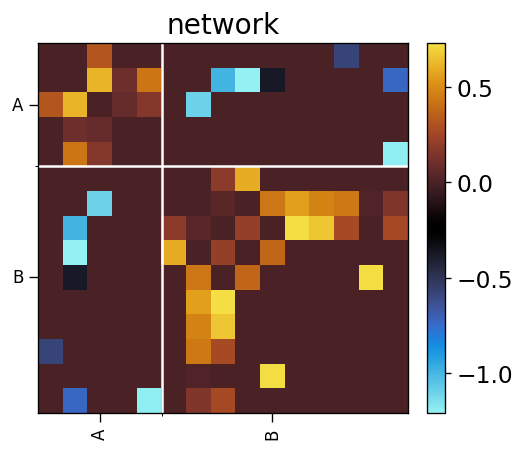

In [8]:
(
    W, 
    roi_labels,
) = generate_connectivity_matrix(
    args
)

args = create_matrix_ticks(args)
args.cmap = cmr.iceburn
# args.cmap = mpl.colormaps['viridis']
display_network(args, W)

sp.io.savemat(
    f"{networks_dir}/2_groups.mat",
    {
        'network':W,
        'roi_labels':roi_labels,
    }
)

In [9]:
stim_rois = [1]
stimulus = np.zeros((W.shape[0],1))
stimulus[stim_rois] = 1.0
roi_labels[stim_rois]

array(['A_01'], dtype='<U4')

In [10]:
args.gamma = 0.75 * np.ones(shape=(args.num_rois.sum(),1))

model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_model

in_dict = {}
in_dict['Kij'] = W
in_dict['gamma'] = matlab.double(args.gamma)
in_dict['bu'] = 1.0
in_dict['bl'] = -1.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 1.0
in_dict['T'] = 10.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)

out_dict = simulate(eng, model_path, model, in_dict)

In [11]:
sp.io.savemat(
    f"{bdmodels_dir}/in_dict.mat",
    in_dict,
)

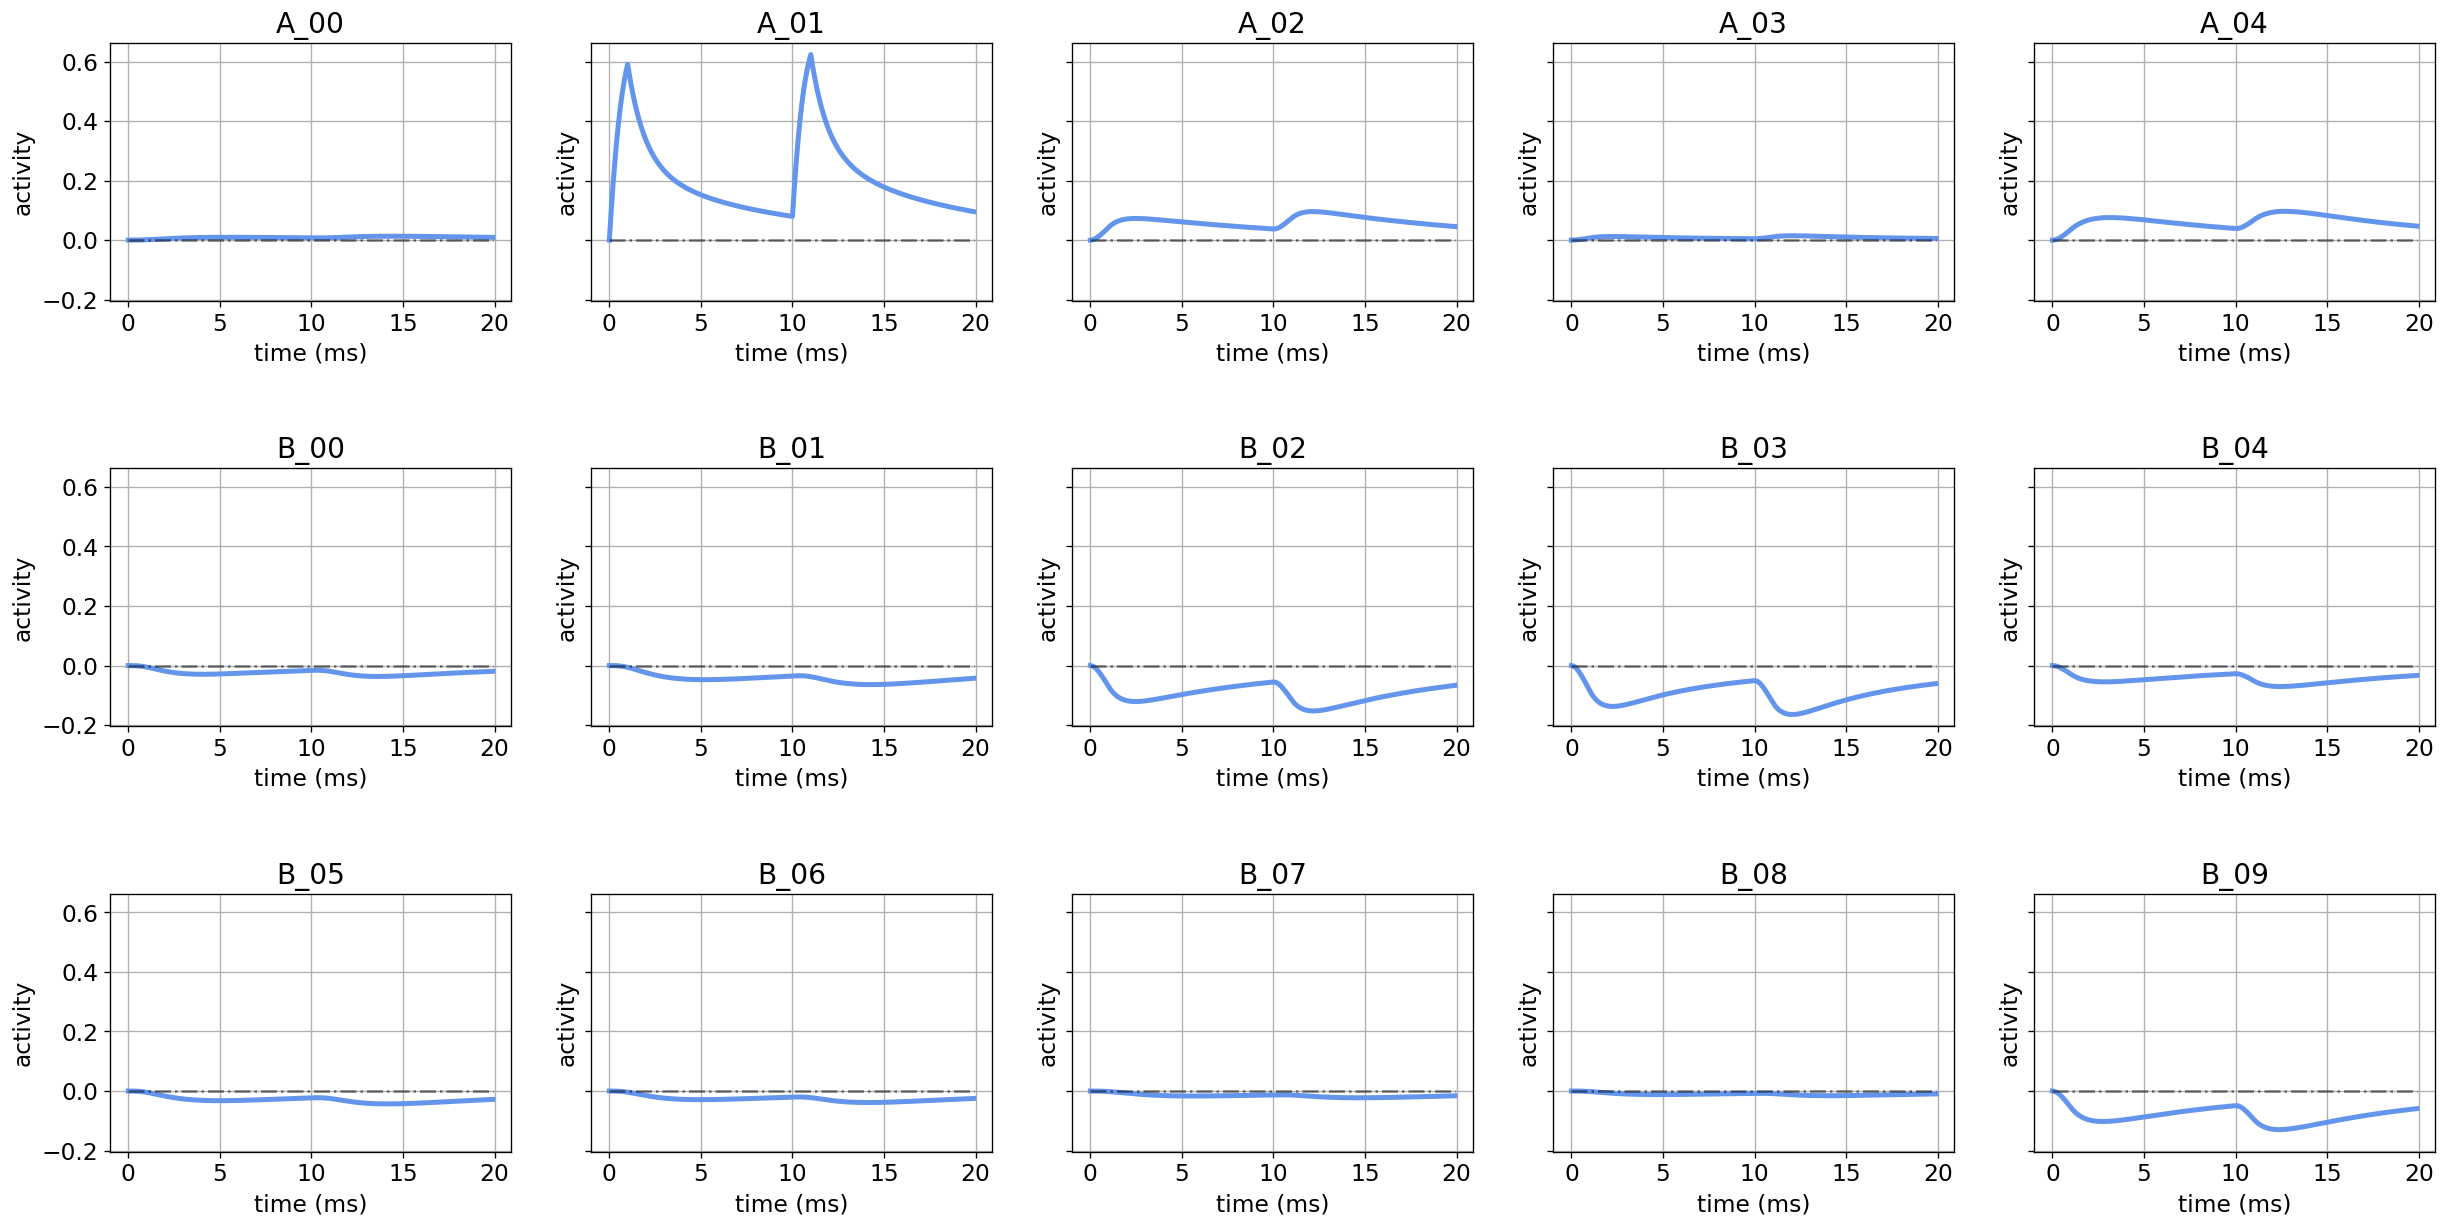

In [12]:
args.subplot_layout = 'row-col'
args.num_rois = np.sum(args.num_rois)
plot_roi_time_series(
    args, 
    out_dict['t'],
    out_dict['x'],
    roi_labels,
)

### randomly permuted networks

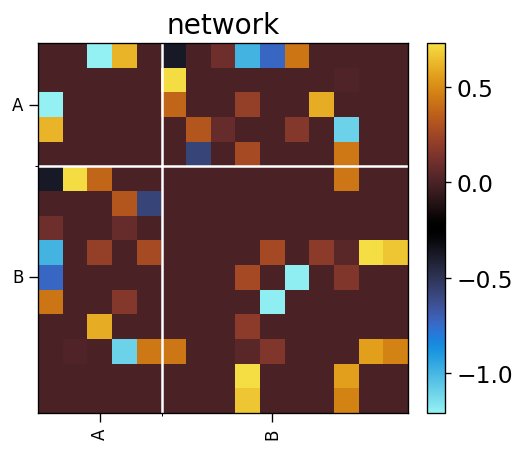

In [13]:
ordering = np.random.permutation(W.shape[0])
W_ = W[np.ix_(ordering, ordering)].copy()
display_network(args, W_)

In [14]:
ordering

array([ 1, 13,  8,  2, 12,  9,  0,  3,  7, 14,  4,  5,  6, 10, 11])

In [15]:
model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_model

iin_dict = {}
in_dict['Kij'] = W_
in_dict['gamma'] = matlab.double(args.gamma)
in_dict['bu'] = 1.0
in_dict['Iamp'] = 5.0
in_dict['tau'] = 2.0
in_dict['T'] = 10.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)


out_dict = simulate(eng, model_path, model, in_dict)

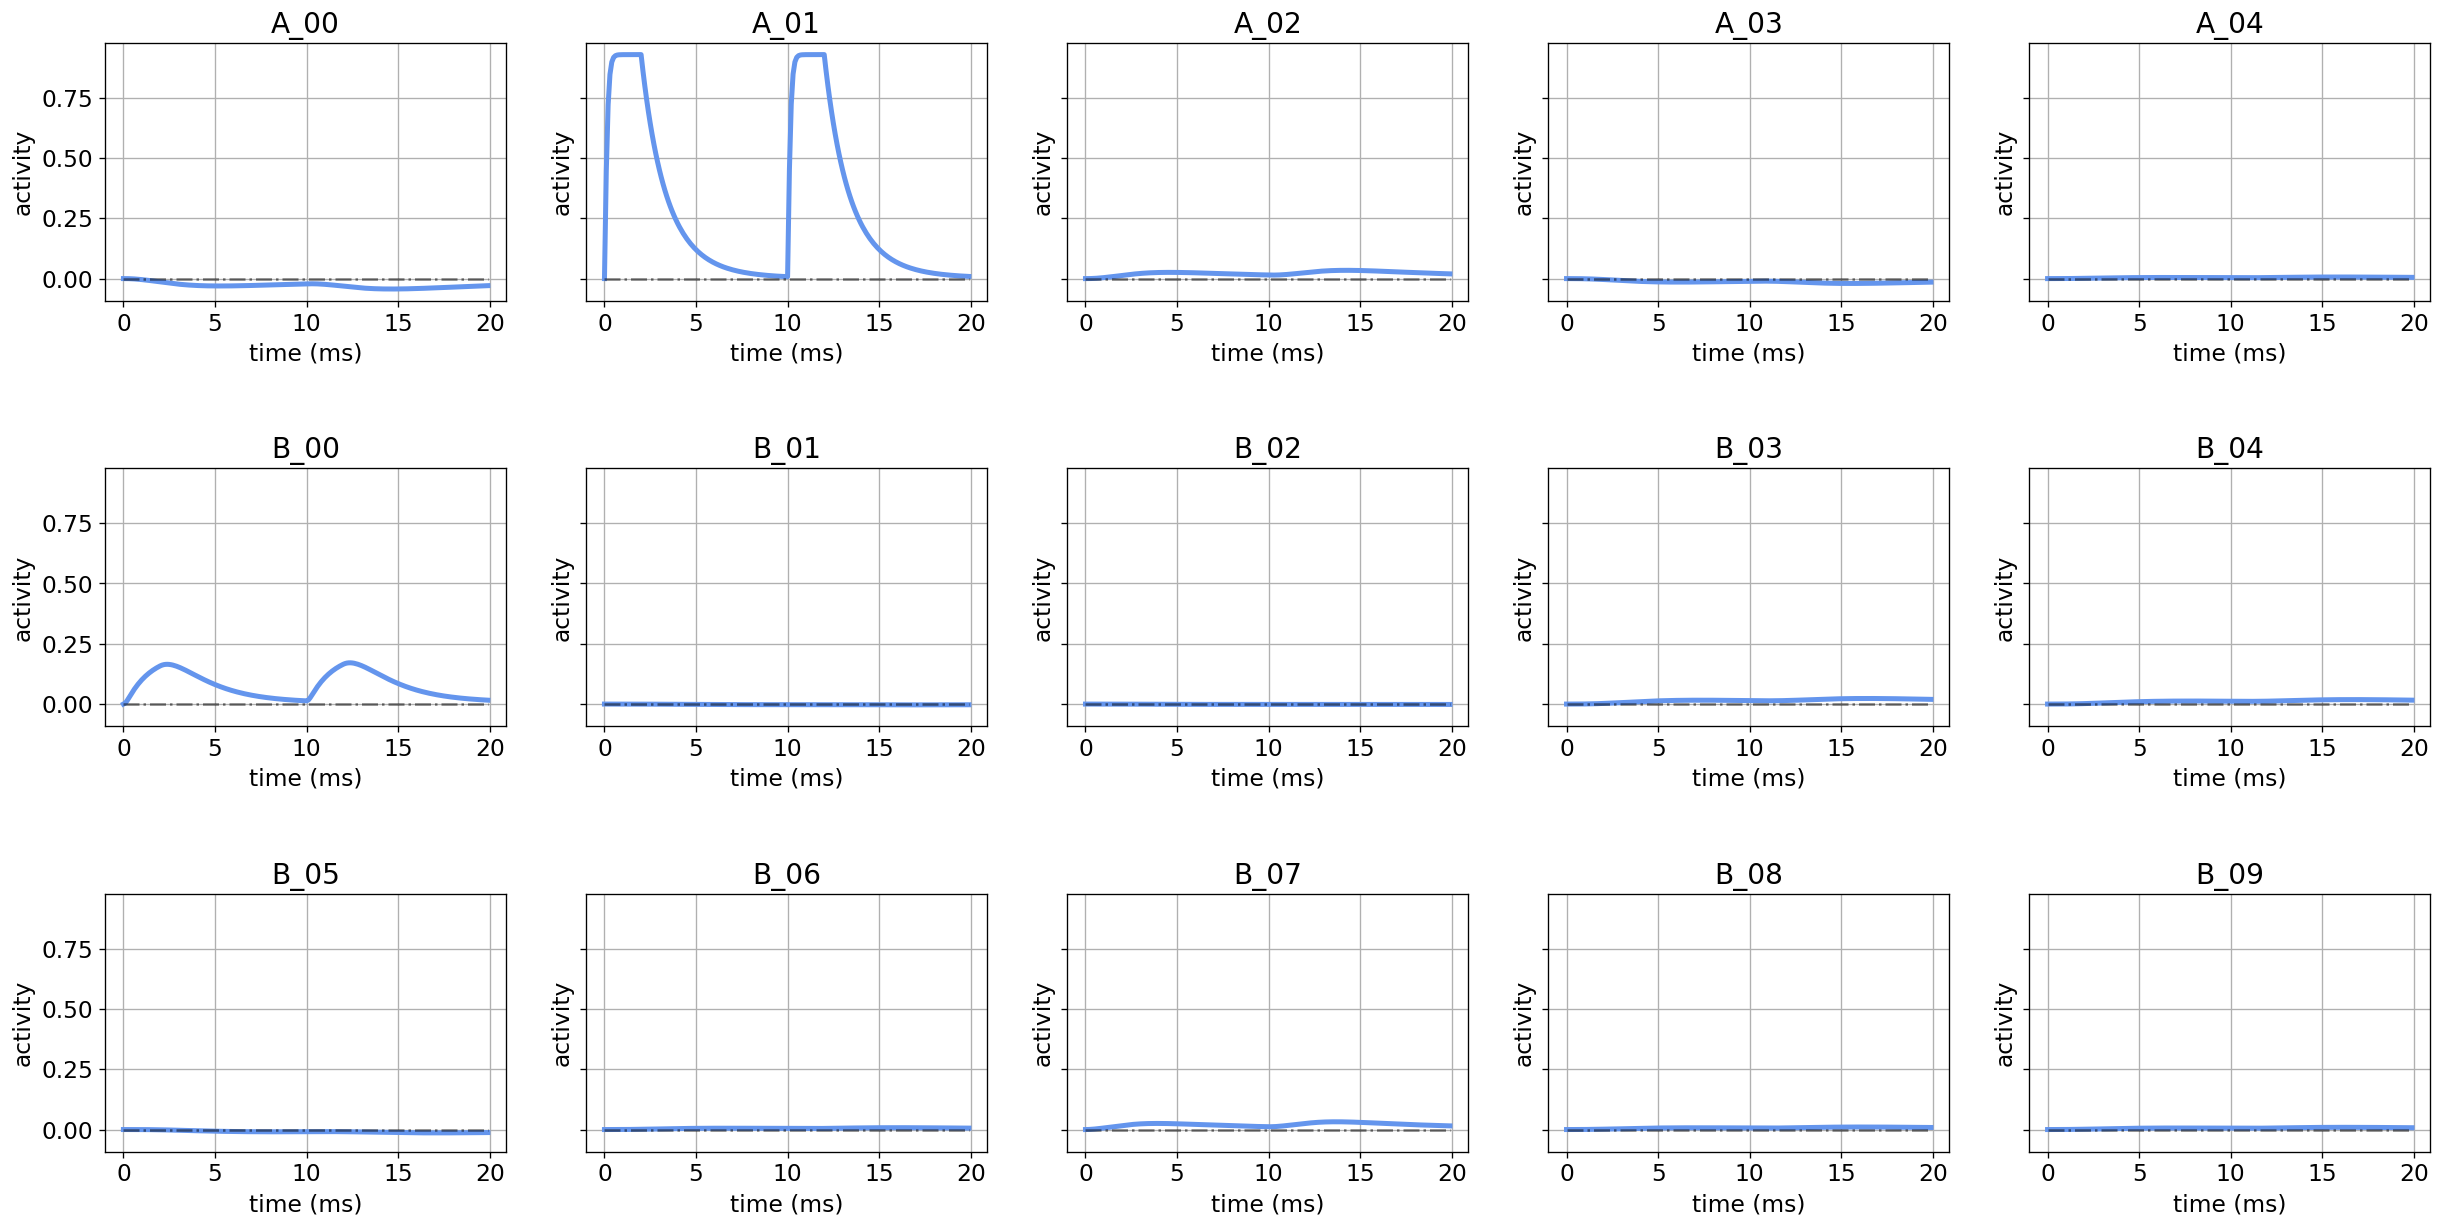

In [16]:
args.subplot_layout = 'row-col'
plot_roi_time_series(
    args, 
    out_dict['t'],
    out_dict['x'],
    roi_labels,
)

## stochastic linear model

### network

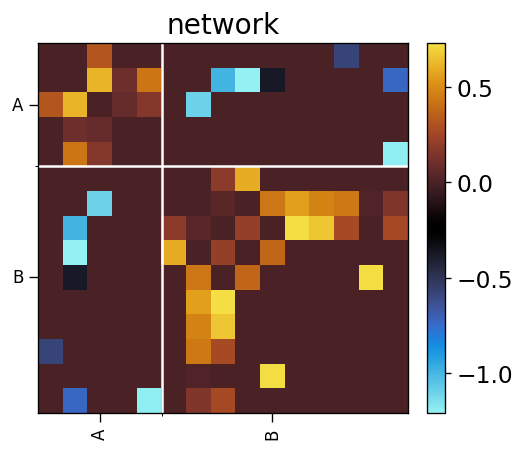

In [18]:
args.cmap = cmr.iceburn
# args.cmap = mpl.colormaps['viridis']
display_network(args, W)

In [17]:
args.gamma = 0.75 * np.ones(shape=(args.num_rois.sum(),1))

model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_sde_model

in_dict = {}
in_dict['Kij'] = W
in_dict['gamma'] = matlab.double(args.gamma)
in_dict['bu'] = 1.0
in_dict['bl'] = -1.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 1.0
in_dict['T'] = 10.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)
in_dict['sigma'] = 0.05

sp.io.savemat(
    f"{bdmodels_dir}/in_dict_LinearSDE.mat",
    in_dict,
)

out_dict = simulate(eng, model_path, model, in_dict)

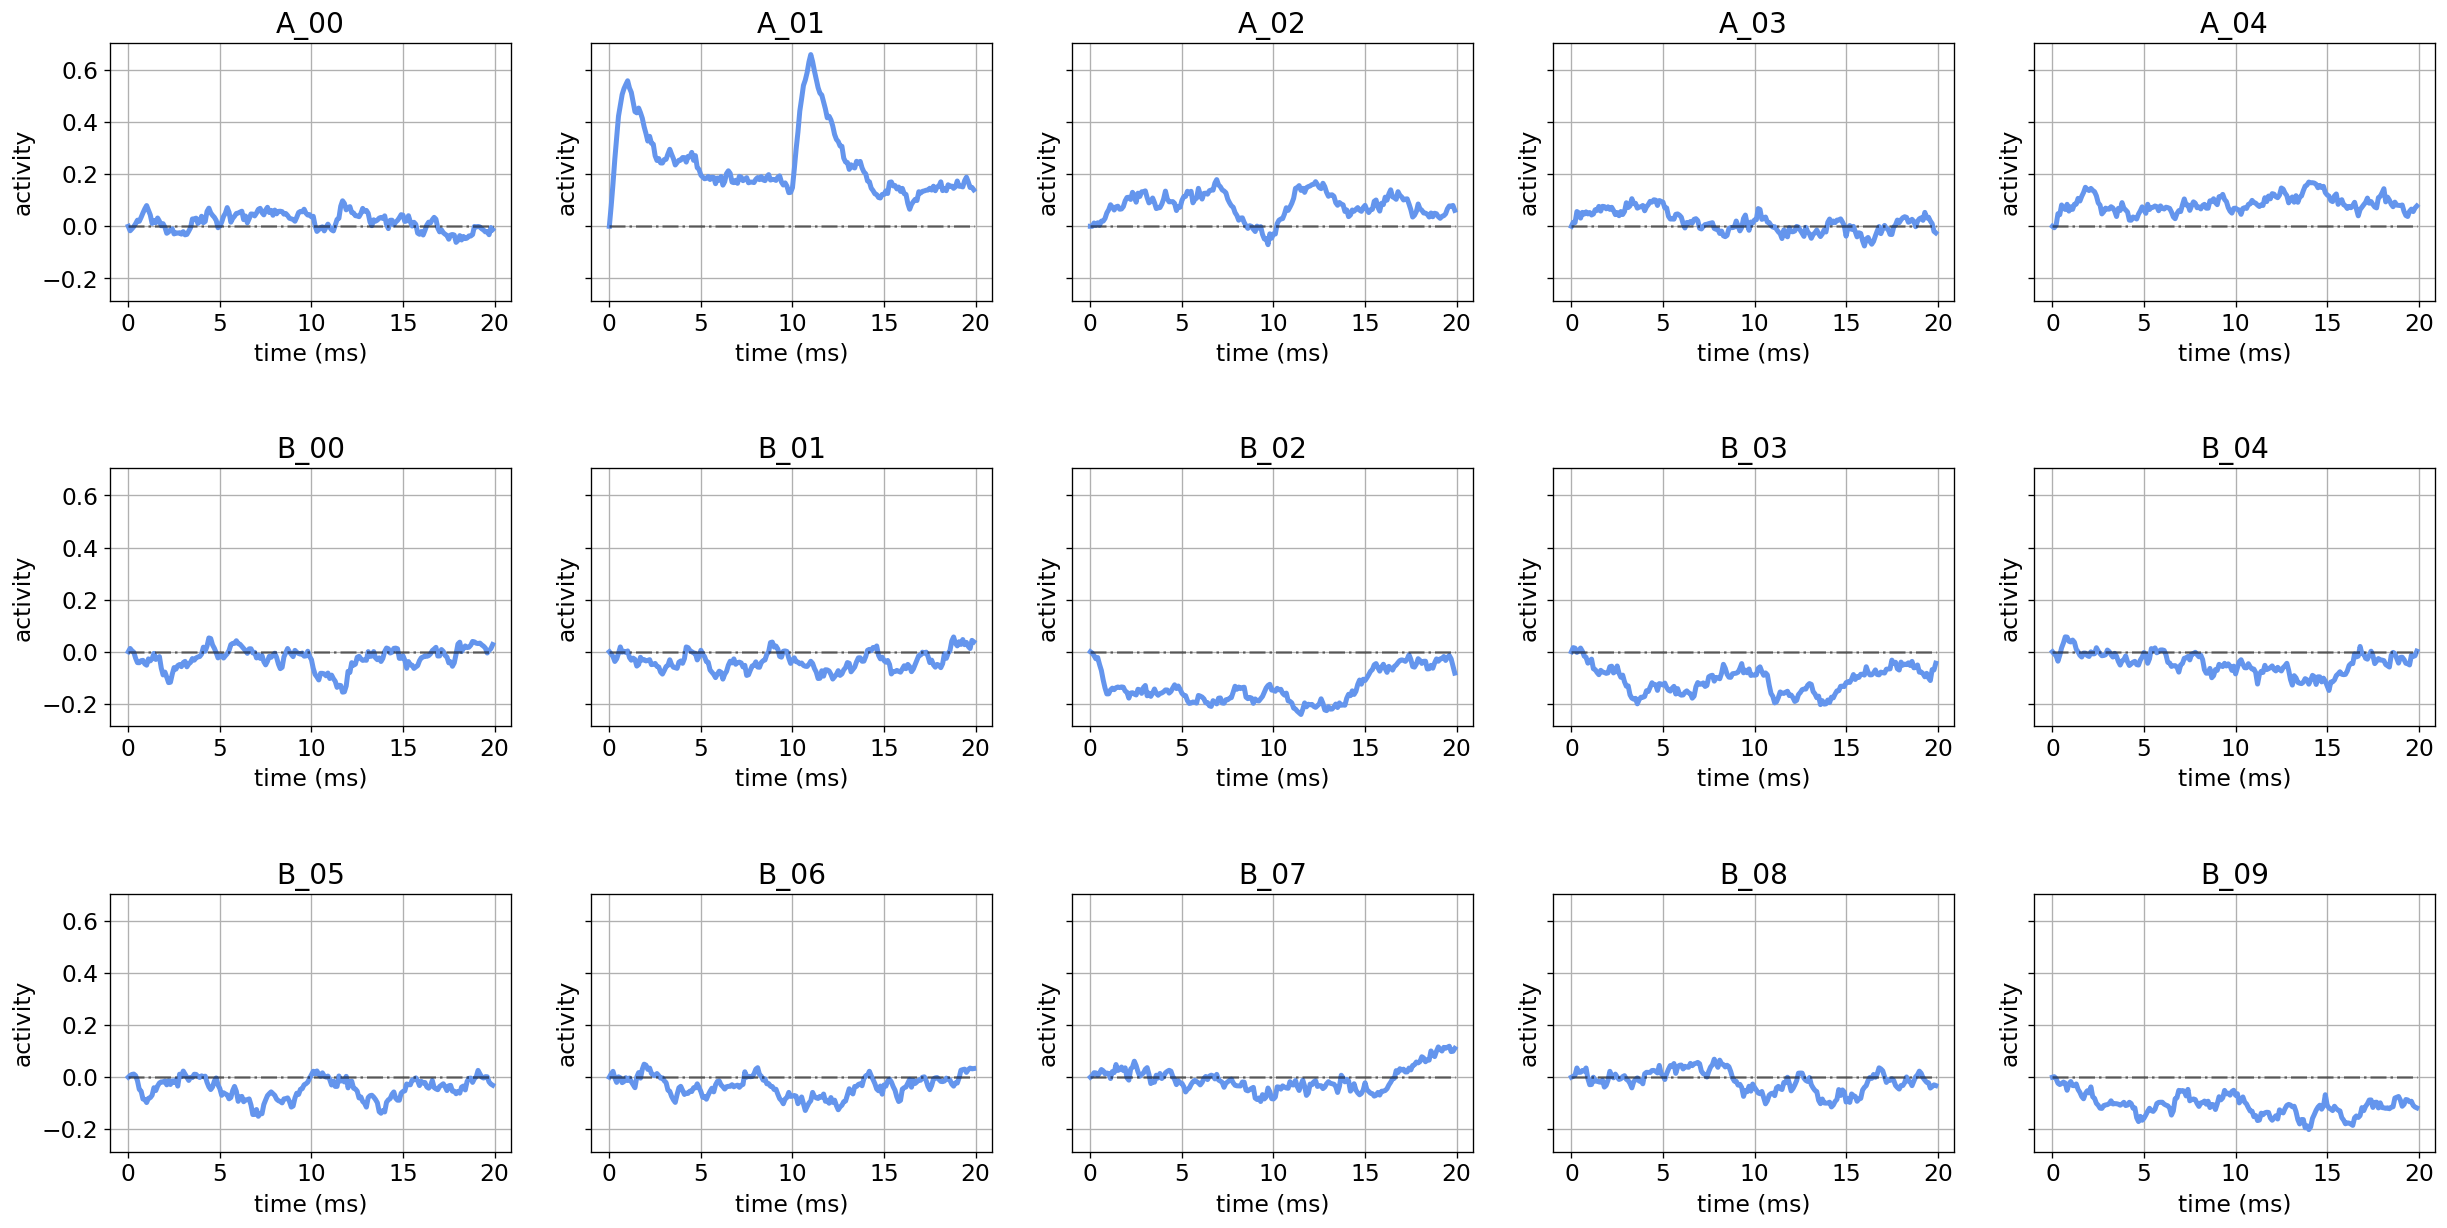

In [18]:
args.subplot_layout = 'row-col'
plot_roi_time_series(
    args, 
    out_dict['t'],
    out_dict['x'],
    roi_labels,
)

In [17]:
# eng.quit()